In [6]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import os
#import imageio.v2 as imageio
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow import keras
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout 
from keras.layers import Conv2DTranspose
from keras.layers import concatenate
from termcolor import colored

In [7]:
image_path = 'drone/dataset/semantic_drone_dataset/original_images/'
mask_path = 'drone/dataset/semantic_drone_dataset/label_images_semantic/'

In [8]:
image_list = os.listdir(image_path)
im_list = image_list
mask_list = os.listdir(mask_path)

In [9]:
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in im_list]

for x in range(0,400):
    mask_list[x] = mask_list[x][:-4] + '.png'

Text(0.5, 1.0, 'Segmentation')

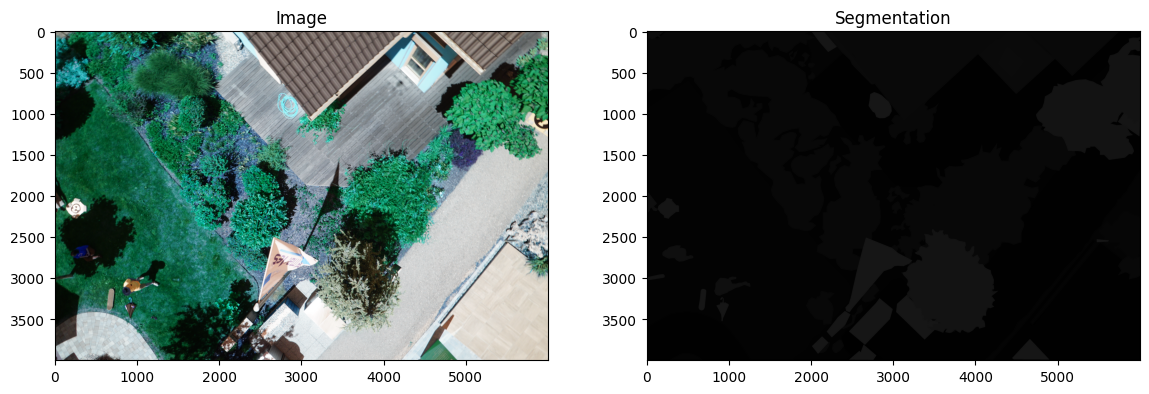

In [10]:
N = 56
img = cv2.imread(image_list[N])
mask = cv2.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask)
arr[1].set_title('Segmentation')

In [11]:
import tensorflow as tf
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'drone\\dataset\\semantic_drone_dataset\\original_images\\000.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'drone\\dataset\\semantic_drone_dataset\\label_images_semantic\\000.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'drone\\dataset\\semantic_drone_dataset\\original_images\\001.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'drone\\dataset\\semantic_drone_dataset\\label_images_semantic\\001.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'drone\\dataset\\semantic_drone_dataset\\original_images\\002.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'drone\\dataset\\semantic_drone_dataset\\label_images_semantic\\002.png'>)


In [12]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'drone/dataset/semantic_drone_dataset/original_images/000.jpg', shape=(), dtype=string)
tf.Tensor(b'drone/dataset/semantic_drone_dataset/label_images_semantic/000.png', shape=(), dtype=string)


In [13]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (256, 256), method='nearest')
    input_mask = tf.image.resize(mask, (256, 256), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [14]:
def summary(model):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    result = []
    for layer in model.layers:
        descriptors = [layer.__class__.__name__, layer.output_shape, layer.count_params()]
        if (type(layer) == Conv2D):
            descriptors.append(layer.padding)
            descriptors.append(layer.activation.__name__)
            descriptors.append(layer.kernel_initializer.__class__.__name__)
        if (type(layer) == MaxPooling2D):
            descriptors.append(layer.pool_size)
        if (type(layer) == Dropout):
            descriptors.append(layer.rate)
        result.append(descriptors)
    return result

In [15]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    
    conv = Conv2D(n_filters, 
                  3,      
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, 
                  3,   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)      
    
    if max_pooling:
        next_layer = MaxPooling2D(2,strides=2)(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [16]:
input_size=(256, 256, 3)
n_filters = 32
inputs = Input(input_size)
cblock1 = conv_block(inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=inputs, outputs=cblock1)

output1 = [['InputLayer', [(None, 256, 256, 3)], 0],
            ['Conv2D', (None, 256, 256, 32), 896, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 256, 256, 32), 9248, 'same', 'relu', 'HeNormal'],
            ['MaxPooling2D', (None, 128, 128, 32), 0, (2, 2)]]

print('Block 1:')
for layer in summary(model1):
    print(layer)

#comparator(summary(model1), output1)

inputs = Input(input_size)
cblock1 = conv_block(inputs, n_filters * 32, dropout_prob=0.1, max_pooling=True)
model2 = tf.keras.Model(inputs=inputs, outputs=cblock1)

output2 = [['InputLayer', [(None, 256, 256, 3)], 0],
            ['Conv2D', (None, 256, 256, 1024), 28672, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 256, 256, 1024), 9438208, 'same', 'relu', 'HeNormal'],
            ['Dropout', (None, 256, 256, 1024), 0, 0.1],
            ['MaxPooling2D', (None, 128, 128, 1024), 0, (2, 2)]]
           
print('\nBlock 2:')   
for layer in summary(model2):
    print(layer)
    
#comparator(summary(model2), output2)

Block 1:
['InputLayer', [(None, 256, 256, 3)], 0]
['Conv2D', (None, 256, 256, 32), 896, 'same', 'relu', 'HeNormal']
['Conv2D', (None, 256, 256, 32), 9248, 'same', 'relu', 'HeNormal']
['MaxPooling2D', (None, 128, 128, 32), 0, (2, 2)]

Block 2:
['InputLayer', [(None, 256, 256, 3)], 0]
['Conv2D', (None, 256, 256, 1024), 28672, 'same', 'relu', 'HeNormal']
['Conv2D', (None, 256, 256, 1024), 9438208, 'same', 'relu', 'HeNormal']
['Dropout', (None, 256, 256, 1024), 0, 0.1]
['MaxPooling2D', (None, 128, 128, 1024), 0, (2, 2)]


In [17]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    
    up = Conv2DTranspose(
                 n_filters,    
                 3,   
                 strides=2,
                 padding='same')(expansive_input)

    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   
                 3,     
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  
                 3,   
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    
    return conv

In [18]:
input_size1=(32, 32, 256)
input_size2 = (64, 64, 128)
n_filters = 32
expansive_inputs = Input(input_size1)
contractive_inputs =  Input(input_size2)
cblock1 = upsampling_block(expansive_inputs, contractive_inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=[expansive_inputs, contractive_inputs], outputs=cblock1)

output1 = [['InputLayer', [(None, 32, 32, 256)], 0],
            ['Conv2DTranspose', (None, 64, 64, 32), 73760],
            ['InputLayer', [(None, 64, 64, 128)], 0],
            ['Concatenate', (None, 64, 64, 160), 0],
            ['Conv2D', (None, 64, 64, 32), 46112, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 64, 64, 32), 9248, 'same', 'relu', 'HeNormal']]

print('Block 1:')
for layer in summary(model1):
    print(layer)

#comparator(summary(model1), output1)

Block 1:
['InputLayer', [(None, 32, 32, 256)], 0]
['Conv2DTranspose', (None, 64, 64, 32), 73760]
['InputLayer', [(None, 64, 64, 128)], 0]
['Concatenate', (None, 64, 64, 160), 0]
['Conv2D', (None, 64, 64, 32), 46112, 'same', 'relu', 'HeNormal']
['Conv2D', (None, 64, 64, 32), 9248, 'same', 'relu', 'HeNormal']


In [19]:
def unet_model(input_size=(256, 256, 3), n_filters=32, n_classes=23):
    inputs = Input(input_size)
    
    cblock1 = conv_block(inputs, n_filters)
    
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0.3) 
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=None) 
    
    ublock6 = upsampling_block(cblock5[0],cblock4[1] ,  n_filters * 8)
     
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters*1)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [20]:
unet_model_output = [['InputLayer', [(None, 256, 256, 3)], 0],
['Conv2D', (None, 256, 256, 32), 896, 'same', 'relu', 'HeNormal'],
['Conv2D', (None, 256, 256, 32), 9248, 'same', 'relu', 'HeNormal'],
['MaxPooling2D', (None, 128, 128, 32), 0, (2, 2)],
['Conv2D', (None, 128, 128, 64), 18496, 'same', 'relu', 'HeNormal'],
['Conv2D', (None, 128, 128, 64), 36928, 'same', 'relu', 'HeNormal'],
['MaxPooling2D', (None, 64, 64, 64), 0, (2, 2)],
['Conv2D', (None, 64, 64, 128), 73856, 'same', 'relu', 'HeNormal'],
['Conv2D', (None, 64, 64, 128), 147584, 'same', 'relu', 'HeNormal'],
['MaxPooling2D', (None, 32, 32, 128), 0, (2, 2)],
['Conv2D', (None, 32, 32, 256), 295168, 'same', 'relu', 'HeNormal'],
['Conv2D', (None, 32, 32, 256), 590080, 'same', 'relu', 'HeNormal'],
['Dropout', (None, 32, 32, 256), 0, 0.3],
['MaxPooling2D', (None, 16, 16, 256), 0, (2, 2)],
['Conv2D', (None, 16, 16, 512), 1180160, 'same', 'relu', 'HeNormal'],
['Conv2D', (None, 16, 16, 512), 2359808, 'same', 'relu', 'HeNormal'],
['Dropout', (None, 16, 16, 512), 0, 0.3],
['Conv2DTranspose', (None, 32, 32, 256), 1179904],
['Concatenate', (None, 32, 32, 512), 0],
['Conv2D', (None, 32, 32, 256), 1179904, 'same', 'relu', 'HeNormal'],
['Conv2D', (None, 32, 32, 256), 590080, 'same', 'relu', 'HeNormal'],
['Conv2DTranspose', (None, 64, 64, 128), 295040],
['Concatenate', (None, 64, 64, 256), 0],
['Conv2D', (None, 64, 64, 128), 295040, 'same', 'relu', 'HeNormal'],
['Conv2D', (None, 64, 64, 128), 147584, 'same', 'relu', 'HeNormal'],
['Conv2DTranspose', (None, 128, 128, 64), 73792],
['Concatenate', (None, 128, 128, 128), 0],
['Conv2D', (None, 128, 128, 64), 73792, 'same', 'relu', 'HeNormal'],
['Conv2D', (None, 128, 128, 64), 36928, 'same', 'relu', 'HeNormal'],
['Conv2DTranspose', (None, 256, 256, 32), 18464],
['Concatenate', (None, 256, 256, 64), 0],
['Conv2D', (None, 256, 256, 32), 18464, 'same', 'relu', 'HeNormal'],
['Conv2D', (None, 256, 256, 32), 9248, 'same', 'relu', 'HeNormal'],
['Conv2D', (None, 256, 256, 32), 9248, 'same', 'relu', 'HeNormal'],
['Conv2D', (None, 256, 256, 23), 759, 'same', 'linear', 'GlorotUniform']]

In [21]:
img_height = 256
img_width = 256
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))
#comparator(summary(unet), unet_model_output)

In [22]:
unet.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 256, 256, 32  896         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_7 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d_6[0][0]']               
                                )                                                           

In [23]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(4000, 6000, 1)


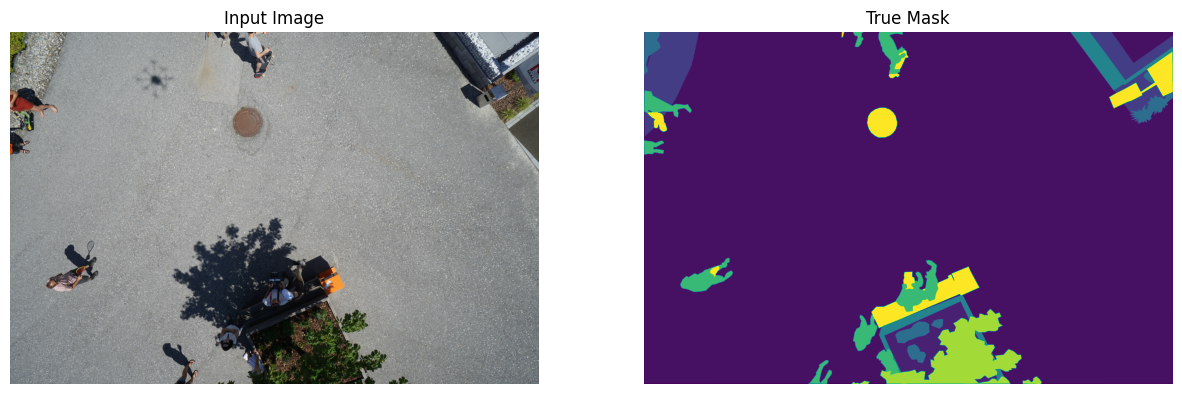

In [25]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(256, 256, 1)


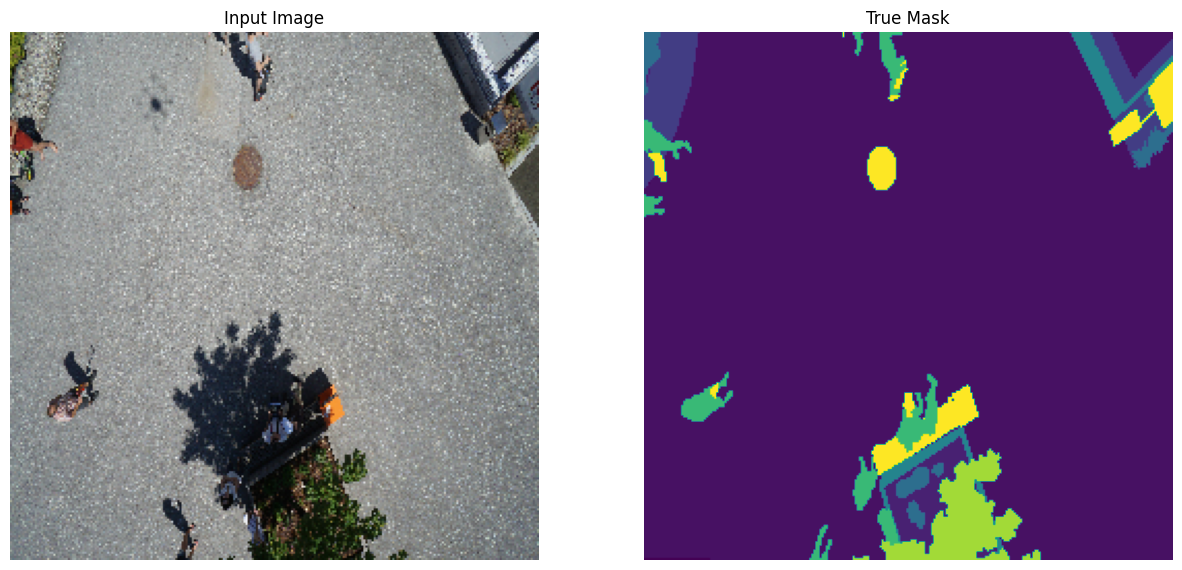

In [26]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

In [27]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights = True)

In [28]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [29]:
EPOCHS = 350
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 8

processed_image_ds=processed_image_ds.shuffle(BUFFER_SIZE)

ts=len(processed_image_ds)
val_dataset=processed_image_ds.skip(int(ts*0.8))
train_dataset=processed_image_ds.take(int(ts*0.8))

print(len(val_dataset))
print(len(train_dataset))

val_dataset.batch(BATCH_SIZE)
train_dataset.batch(BATCH_SIZE)

train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

print(len(val_dataset))
print(len(train_dataset))
print(processed_image_ds.element_spec)


80
320
10
40
(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))


In [30]:
model_history = unet.fit(train_dataset,validation_data=val_dataset,epochs=EPOCHS,callbacks=[es])

Epoch 1/350
40/40 [==============================] - 92s 1s/step - loss: 2.2986 - accuracy: 0.4194 - val_loss: 1.9161 - val_accuracy: 0.5095
Epoch 2/350
40/40 [==============================] - 8s 206ms/step - loss: 1.7883 - accuracy: 0.5321 - val_loss: 1.6788 - val_accuracy: 0.5562
Epoch 3/350
40/40 [==============================] - 8s 207ms/step - loss: 1.6045 - accuracy: 0.5620 - val_loss: 1.5518 - val_accuracy: 0.5585
Epoch 4/350
40/40 [==============================] - 8s 207ms/step - loss: 1.5317 - accuracy: 0.5673 - val_loss: 1.4954 - val_accuracy: 0.5895
Epoch 5/350
40/40 [==============================] - 8s 208ms/step - loss: 1.4028 - accuracy: 0.5941 - val_loss: 1.3927 - val_accuracy: 0.5750
Epoch 6/350
40/40 [==============================] - 8s 205ms/step - loss: 1.4974 - accuracy: 0.5693 - val_loss: 1.4268 - val_accuracy: 0.5778
Epoch 7/350
40/40 [==============================] - 8s 205ms/step - loss: 1.3645 - accuracy: 0.6029 - val_loss: 1.4319 - val_accuracy: 0.5917
E

In [31]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

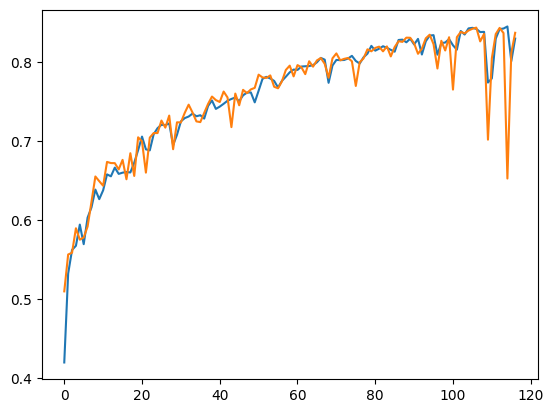

In [32]:
plt.plot(model_history.history["accuracy"])
plt.plot(model_history.history["val_accuracy"])

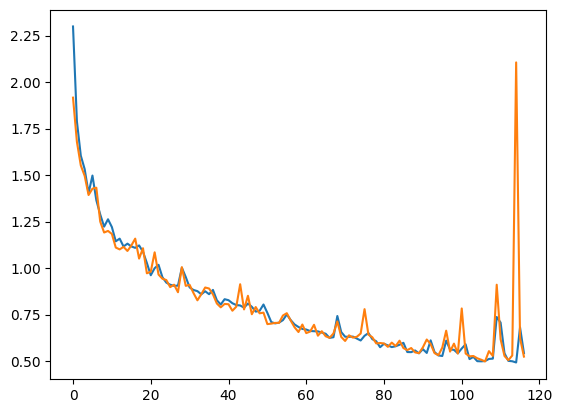

In [33]:
plt.plot(model_history.history["loss"])
plt.plot(model_history.history["val_loss"])

In [34]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 260ms/step


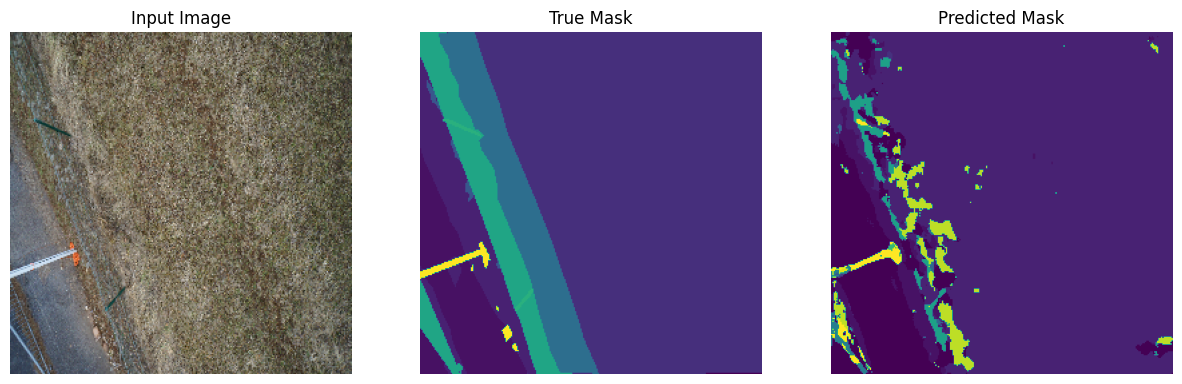

1/1 [==============================] - 0s 48ms/step


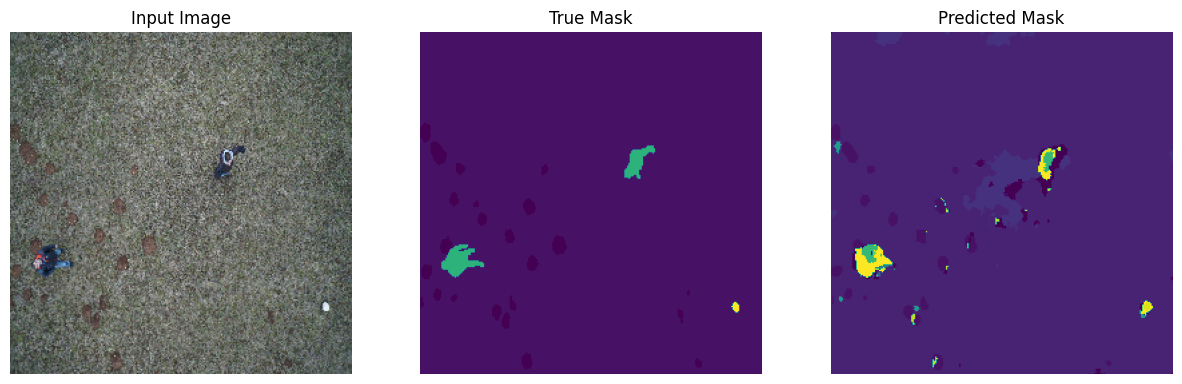

1/1 [==============================] - 0s 47ms/step


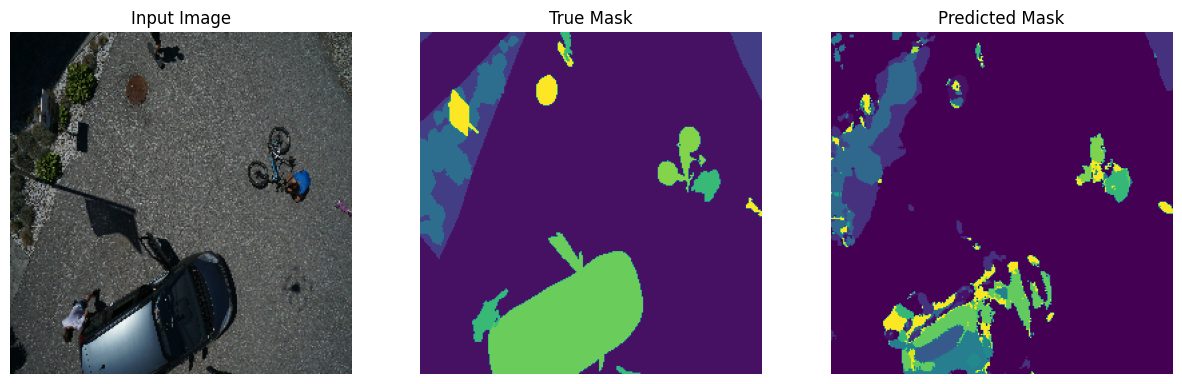

In [35]:
show_predictions(val_dataset, 3)

In [36]:
# save model as h5 file
unet.save('unet.h5')

### Cross validation

In [41]:
# Perform cross validation
from sklearn.model_selection import KFold, cross_val_score

def crossValidation(model, X_train_processed, y_train_processed, n_splits):
    # Create a KFold object to split the data into k-folds
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Compute the cross-validation scores
    cv_scores = cross_val_score(model, X_train_processed, y_train_processed, cv=kf, scoring='r2')

    # Compute the mean and standard deviation of the cross-validation scores
    mean_cv_score = cv_scores.mean()
    std_cv_score = cv_scores.std()

    print("Mean score: ", mean_cv_score)
    print("Standard deviation score: ", std_cv_score)

### Evaluation

In [37]:
unet_loaded = keras.models.load_model('unet.h5')

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay, roc_curve
from keras.metrics import MeanIoU
from keras.utils import to_categorical
from keras import backend as K
import statistics
import seaborn as sns

def evaluateMask(true_mask, predicted_mask): 
    # Flatten the masks to 1D arrays
    true_mask = to_categorical(true_mask.numpy().flatten(), num_classes=23)
    predicted_mask = to_categorical(predicted_mask.numpy().flatten(), num_classes=23)
    
    # Mean Iou Score
    mean_iou = MeanIoU(num_classes=23)
    mean_iou.update_state(true_mask, predicted_mask)
    iou_score = mean_iou.result().numpy()
    
    # Confusion matrix
    cm = confusion_matrix(np.argmax(true_mask, axis=1), np.argmax(predicted_mask, axis=1), labels=range(23))
    
    # Calculate the metrics
    tp = np.diag(cm)
    fp = np.sum(cm, axis=0) - tp
    fn = np.sum(cm, axis=1) - tp
    tn = np.sum(cm) - (tp + fp + fn)

    sns.heatmap(cm, annot=True)

    precision = tp / (tp + fp)
    precision_mean = np.mean(np.nan_to_num(precision))
    recall = tp / (tp + fn)
    recall_mean = np.mean(np.nan_to_num(recall))
    accuracy = np.sum(tp) / np.sum(cm)
    f1_score = 2 * precision * recall / (precision + recall)
    f1_score_mean = np.mean(np.nan_to_num(f1_score))
    dice_coefficient = (2 * tp) / (2 * tp + fp + fn)
    dice_coefficient_mean = np.mean(np.nan_to_num(dice_coefficient))
    
    # Print the results
    print("Classification Report:\n", classification_report(np.argmax(true_mask, axis=1), np.argmax(predicted_mask, axis=1)))
    print("Mean IoU score:", iou_score)
    print("Recall:", recall_mean)
    print("Precision:", precision_mean)
    print("Accuracy:", accuracy)
    print("F1 score:", f1_score_mean)
    print("Dice coefficient:", dice_coefficient_mean)

    # Plot the confusion matrix
    sns.heatmap(cm, xticklabels=['P0', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7'
                                 , 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14'
                                 , 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 
                                 'P21', 'P22'], 
                yticklabels=['A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7'
                            , 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15'
                            , 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22'],
    annot=True, fmt='d', annot_kws={'fontsize':6}, cmap="YlGnBu")

In [39]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

1/1 [==============================] - 0s 251ms/step


c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\EzLaser\anacond

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.01      0.01       176
           1       0.91      0.78      0.84     18813
           2       0.73      0.54      0.62      3518
           3       0.89      0.94      0.92     12868
           4       0.28      0.45      0.34      1261
           5       0.00      0.00      0.00         0
           6       0.32      0.02      0.04       525
           7       0.00      0.00      0.00         0
           8       0.82      0.86      0.84     14971
           9       0.97      0.95      0.96      3982
          10       0.16      0.60      0.26      1019
          11       0.11      0.02      0.03       212
          13       0.01      0.03      0.02        38
          14       0.00      0.00      0.00         1
          15       0.50      0.37      0.43       310
          17       0.00      0.00      0.00         0
          18       0.00      0.00      0.00         0
   

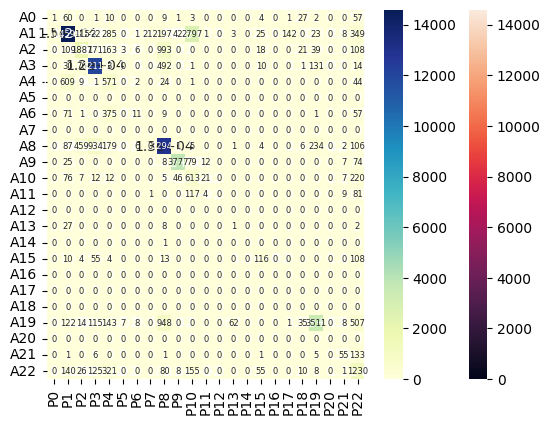

In [40]:
for image, mask in val_dataset.take(1):
    output = unet_loaded.predict(image)

np.seterr(divide='ignore', invalid='ignore')
evaluateMask(mask[0], create_mask(output))